<a href="https://colab.research.google.com/github/nxxk23/PROJECT/blob/main/Model/ClassificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 3.8 MB/s eta 0:00:00


In [3]:
!pip install scikeras

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor

from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import shap


In [5]:
bi3 = pd.read_excel('/content/drive/MyDrive/ckdresearch2023/Assign/Assign8 : SplitFold /binary_3_Group_5_Fold.xlsx')
bi3 = bi3.iloc[:, 1:]

In [6]:
bi3['NATNL'] = bi3['NATNL'].replace({0: 'Asian', 1: 'Asian', 3: 'Asian', 2: 'Non-Asian'})

In [7]:
bi3 = bi3.sort_values(['PatientUID', 'PatientVisitUID'])
bi3['TimeDiff'] = bi3.groupby('PatientUID')['LabCwhen'].diff().dt.days / 365
bi3['TimeDiff'] = bi3['TimeDiff'].fillna(0)

In [8]:
bi3['time_t1'] = pd.to_datetime(bi3['time_t1'])

In [9]:
columns_to_encode = ['VisitLocation', 'Group', 'NATNL']

# Apply label encoding using map
for column in columns_to_encode:
    encoding_map = {category: i for i, category in enumerate(bi3[column].unique())}
    bi3[column] = bi3[column].map(encoding_map)

In [10]:
def categorize_eGFR(eGFR_value):
    if eGFR_value >= 90:
        return 0
    elif eGFR_value >= 60:
        return 1
    elif eGFR_value >= 30:
        return 2
    elif eGFR_value >= 15:
        return 3
    else:
        return 4

bi3['Stage'] = bi3['eGFR_t1'].apply(categorize_eGFR)

# GridSearch

In [11]:
import json

json_file_path = '/content/drive/MyDrive/ckdresearch2023/Assign/GridSearch/xgb_group_binary3.json'
with open(json_file_path, 'r') as f:
    xgb_group_binary3 = json.load(f)

print(xgb_group_binary3)

[{'fold': 1, 'best_params': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}, 'best_score': 0.6493326424126196}, {'fold': 2, 'best_params': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}, 'best_score': 0.6464102364749543}, {'fold': 3, 'best_params': {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50}, 'best_score': 0.6502726006734658}, {'fold': 4, 'best_params': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}, 'best_score': 0.6489193831299095}, {'fold': 5, 'best_params': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}, 'best_score': 0.6492882747934101}]


In [12]:
import json

json_file_path = '/content/drive/MyDrive/ckdresearch2023/Assign/GridSearch/rf_group_binary3.json'
with open(json_file_path, 'r') as f:
    rf_group_binary3 = json.load(f)

print(rf_group_binary3)

[{'fold': 1, 'best_params': {'bootstrap': False, 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}, 'best_score': 0.6359939377634444}, {'fold': 2, 'best_params': {'bootstrap': False, 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 150}, 'best_score': 0.6363789957902357}, {'fold': 3, 'best_params': {'bootstrap': False, 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 150}, 'best_score': 0.6361862231773203}, {'fold': 4, 'best_params': {'bootstrap': False, 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}, 'best_score': 0.6346183397692711}, {'fold': 5, 'best_params': {'bootstrap': False, 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 150}, 'best_score': 0.6374801150718877}]


# Split

In [13]:
bi3_X = bi3.drop(['Group', 'PatientUID', 'PatientVisitUID', 'eGFR_t1', 'time_t1', 'StartDTTM', 'EndDttm',
                    'LabCwhen', 'LabLocation', 'Fold','Slopes','Stage'], axis=1)
bi3_y = bi3['Group']

In [14]:

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=None)
X = bi3.drop(['PatientUID', 'PatientVisitUID', 'eGFR_t1', 'time_t1', 'StartDTTM', 'EndDttm',
                'LabCwhen', 'LabLocation', 'Fold', 'Slopes','Group','Stage'], axis=1)
y = bi3['Group']
all_folds = bi3['Fold'].unique()
X_train_scaled_list_bi3 = []
y_train_list_bi3 = []
X_test_scaled_list_bi3 = []
y_test_list_bi3 = []
for train_folds, test_fold in kf.split(all_folds):
    train_folds = all_folds[train_folds]
    val_fold = all_folds[test_fold][0]
    train_indices = bi3['Fold'].isin(train_folds)
    test_indices = bi3['Fold'] == val_fold
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_train_scaled_list_bi3.append(X_train_scaled)
    y_train_list_bi3.append(y_train)
    X_test_scaled_list_bi3.append(X_test_scaled)
    y_test_list_bi3.append(y_test)
for fold, (X_train_scaled_fold, y_train_fold, X_test_scaled_fold, y_test_fold, train_fold_indices) in enumerate(
        zip(X_train_scaled_list_bi3, y_train_list_bi3, X_test_scaled_list_bi3, y_test_list_bi3, kf.split(all_folds))
):
    train_folds, test_fold = train_fold_indices
    print(f"Training set size: {X_train_scaled_fold.shape}")
    print(f"Test set size: {X_test_scaled_fold.shape}")
    print(f"Folds in training set: {train_folds.tolist()}")
    print(f"Folds in test set: {test_fold}")
    print("---\n")


Training set size: (42027, 120)
Test set size: (10593, 120)
Folds in training set: [0, 1, 2, 3]
Folds in test set: [4]
---

Training set size: (41978, 120)
Test set size: (10642, 120)
Folds in training set: [0, 1, 2, 4]
Folds in test set: [3]
---

Training set size: (42274, 120)
Test set size: (10346, 120)
Folds in training set: [0, 1, 3, 4]
Folds in test set: [2]
---

Training set size: (42184, 120)
Test set size: (10436, 120)
Folds in training set: [1, 2, 3, 4]
Folds in test set: [0]
---

Training set size: (42017, 120)
Test set size: (10603, 120)
Folds in training set: [0, 2, 3, 4]
Folds in test set: [1]
---



# XGB

In [147]:
from xgboost import XGBClassifier

In [148]:
binary3_X = bi3.drop(['Group', 'PatientUID', 'PatientVisitUID', 'eGFR_t1', 'time_t1', 'StartDTTM', 'EndDttm',
               'LabCwhen', 'LabLocation','Fold','Slopes','Stage'], axis=1)
binary3_y = bi3['Group']

In [149]:
binary3_label_encoder = LabelEncoder()
bi3['Group'] = binary3_label_encoder.fit_transform(bi3['Group'])

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=None)
binary3_all_folds = bi3['Fold'].unique()

xgb_metrics_list = []
binary3_accuracy_per_fold = []
binary3_conf_mat_list = []
binary3_precision_per_fold = []
binary3_recall_per_fold = []
binary3_f1_per_fold = []
binary3_loss_per_fold = []
shap_values_list = []

all_y_true_xgb = []
all_y_pred_proba_xgb = []


In [150]:
for fold, (train_folds, test_fold) in enumerate(kf.split(binary3_all_folds)):
    train_folds = binary3_all_folds[train_folds]
    test_fold = binary3_all_folds[test_fold][0]
    train_indices = bi3['Fold'].isin(train_folds)
    test_indices = bi3['Fold'] == test_fold

    binary3_X_train, binary3_X_test = binary3_X[train_indices], binary3_X[test_indices]
    binary3_y_train, binary3_y_test = binary3_y[train_indices], binary3_y[test_indices]

    # Scale
    binary3_scaler = StandardScaler()
    binary3_X_train_scaled = binary3_scaler.fit_transform(binary3_X_train)
    binary3_X_test_scaled = binary3_scaler.transform(binary3_X_test)

    # Create and train XGBoost model using best parameters
    best_params = xgb_group_binary3[fold]['best_params']
    model_x2 = XGBClassifier(**best_params, objective='multi:softmax', random_state=42)
    model_x2.fit(binary3_X_train_scaled, binary3_y_train)

    # Make predictions on the test set
    binary3_y_pred = model_x2.predict(binary3_X_test_scaled)

    binary3_y_pred_proba_xgb = model_x2.predict_proba(binary3_X_test_scaled)
    all_y_true_xgb.extend(binary3_y_test)
    all_y_pred_proba_xgb.extend(binary3_y_pred_proba_xgb[:, 1])

    # Evaluate performance
    binary3_conf_mat = confusion_matrix(binary3_y_test, binary3_y_pred)
    binary3_conf_mat_list.append(binary3_conf_mat)

    binary3_accuracy = accuracy_score(binary3_y_test, binary3_y_pred)
    binary3_precision = precision_score(binary3_y_test, binary3_y_pred, average='weighted')
    binary3_recall = recall_score(binary3_y_test, binary3_y_pred, average='weighted')
    binary3_f1 = f1_score(binary3_y_test, binary3_y_pred, average='weighted')

    binary3_accuracy_per_fold.append(binary3_accuracy)
    binary3_precision_per_fold.append(binary3_precision)
    binary3_recall_per_fold.append(binary3_recall)
    binary3_f1_per_fold.append(binary3_f1)

    explainer = shap.TreeExplainer(model_x2)
    shap_values = explainer.shap_values(X)
    shap_values_list.append(shap_values)

    xgb_metrics_list.append({
        'Fold': fold + 1,
        'Accuracy': binary3_accuracy_per_fold,
        'Precision': binary3_precision_per_fold,
        'Recall': binary3_recall_per_fold,
        'F1 Score': binary3_f1_per_fold,
    })

In [23]:
import pandas as pd

# Create a DataFrame for performance metrics of each fold
fold_data = {
    "Fold": [f"Fold {fold+1}" for fold in range(len(binary3_accuracy_per_fold))],
    "Accuracy (%)": [accuracy * 100 for accuracy in binary3_accuracy_per_fold],
    "Precision": binary3_precision_per_fold,
    "Recall": binary3_recall_per_fold,
    "F1-Score": binary3_f1_per_fold
}

# Create DataFrame for fold performance
fold_performance_df = pd.DataFrame(fold_data).set_index("Fold")


# Calculate overall performance metrics
overall_metrics = {
    "Accuracy (%)": sum(binary3_accuracy_per_fold) / len(binary3_accuracy_per_fold) * 100,
    "Precision": sum(binary3_precision_per_fold) / len(binary3_precision_per_fold),
    "Recall": sum(binary3_recall_per_fold) / len(binary3_recall_per_fold),
    "F1-Score": sum(binary3_f1_per_fold) / len(binary3_f1_per_fold)
}

# Create DataFrame for overall performance
overall_performance_df = pd.DataFrame(overall_metrics, index=["Overall"])

# Concatenate fold performance DataFrame with overall performance DataFrame
result_xgb = pd.concat([fold_performance_df, overall_performance_df])

# Print the concatenated DataFrame
print("\nXGBoost Performances:")
result_xgb



XGBoost Performances:


,Accuracy (%),Precision,Recall,F1-Score
Fold 1,53.242707,0.510739,0.532427,0.469308
Fold 2,53.631660,0.515032,0.536317,0.478411
Fold 3,53.824469,0.515998,0.538245,0.474125
Fold 4,53.588607,0.511257,0.535886,0.475520
Fold 5,53.382950,0.497425,0.533829,0.470688
Overall,53.534079,0.510090,0.535341,0.473611


In [29]:
print("\nXGBoost Performances:")
print(result_xgb)


XGBoost Performances:
         Accuracy (%)  Precision    Recall  F1-Score
Fold 1      53.242707   0.510739  0.532427  0.469308
Fold 2      53.631660   0.515032  0.536317  0.478411
Fold 3      53.824469   0.515998  0.538245  0.474125
Fold 4      53.588607   0.511257  0.535886  0.475520
Fold 5      53.382950   0.497425  0.533829  0.470688
Overall     53.534079   0.510090  0.535341  0.473611


## ROC

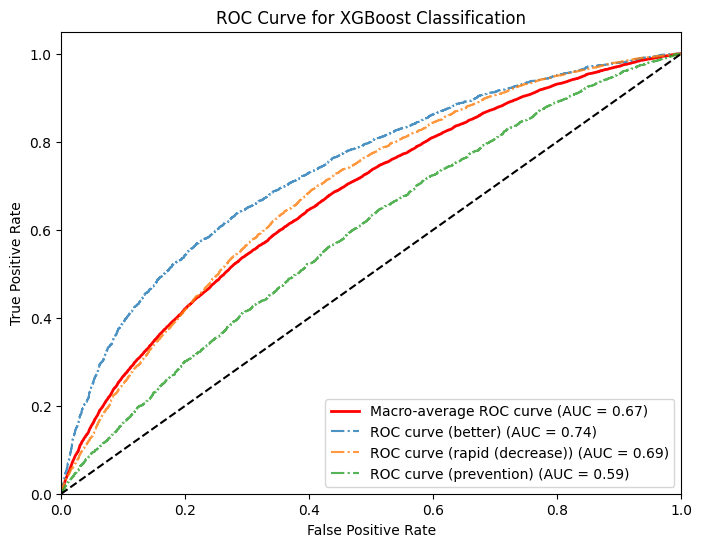

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Convert true labels to one-hot encoded format
binary3_y_test_bin = label_binarize(binary3_y_test, classes=np.unique(binary3_y_test))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = binary3_y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binary3_y_test_bin[:, i], binary3_y_pred_proba_xgb[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and AUC
# First, aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally, average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

class_labels = {0: "better", 1: "rapid (decrease)", 2: "prevention"}

# Plot ROC curve
plt.figure(figsize=(8, 6))

plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:0.2f})', color='red', linestyle='solid', linewidth=2)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve ({class_labels[i]}) (AUC = {roc_auc[i]:0.2f})', alpha = 0.8, linestyle = '-.')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Classification')
plt.legend(loc="lower right")
plt.show()


## shap

In [151]:
shap_values.shape

(52620, 120, 3)

### Class 0: Normal

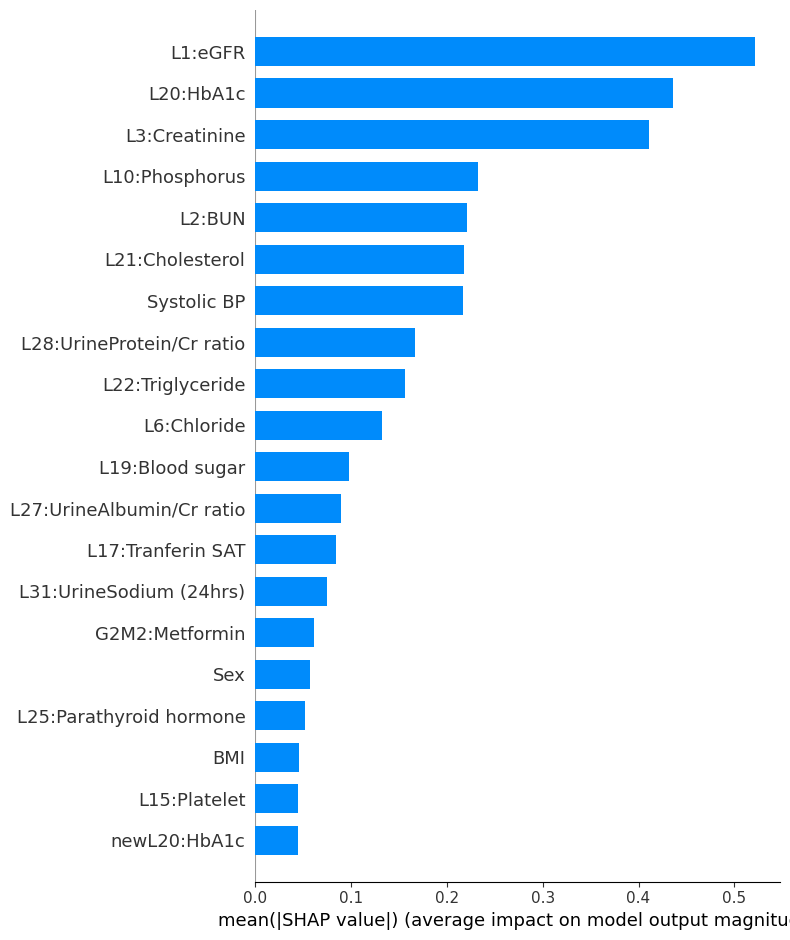

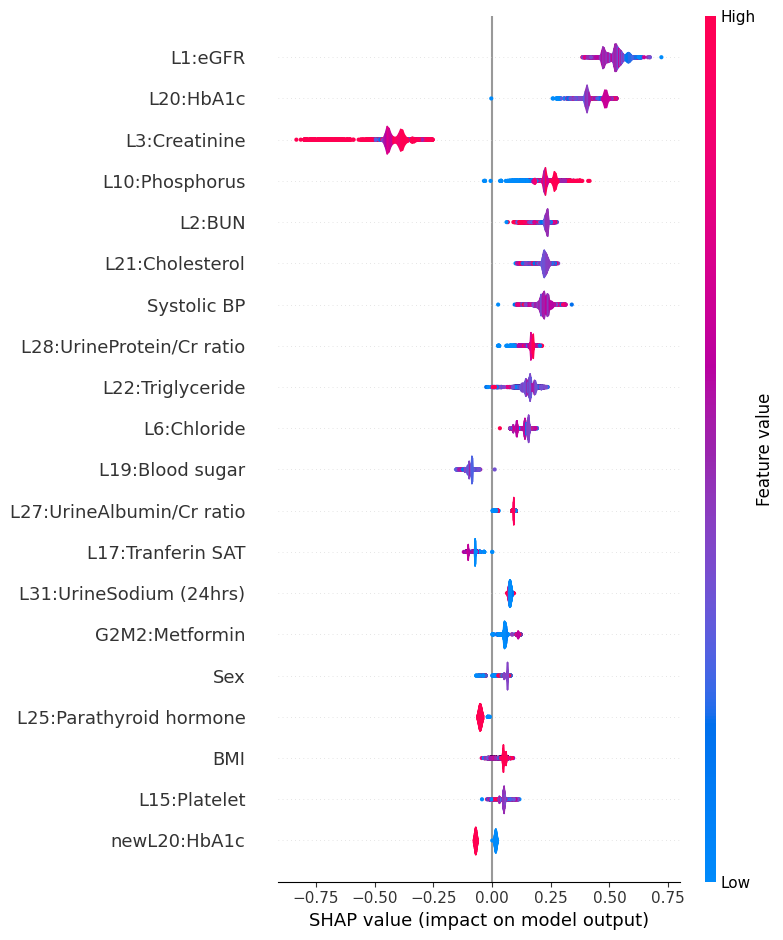

In [160]:
import shap
import matplotlib.pyplot as plt

# Assuming shap_values contains the SHAP values for each fold
fold_to_visualize = 0

# Assuming you want to visualize the first class ==> normal
shap_values = shap_values_list[fold_to_visualize][:X.shape[0], :, 0]

# Summary Plot (Bar Plot)
shap.summary_plot(shap_values, X, feature_names=X.columns, plot_type="bar")

# Summary Plot (Violin Plot)
shap.summary_plot(shap_values, X, feature_names=X.columns, plot_type="violin")

plt.show()


In [219]:
print(shap_values.shape)
print(X.shape)

(52620, 120, 3)
(52620, 120)


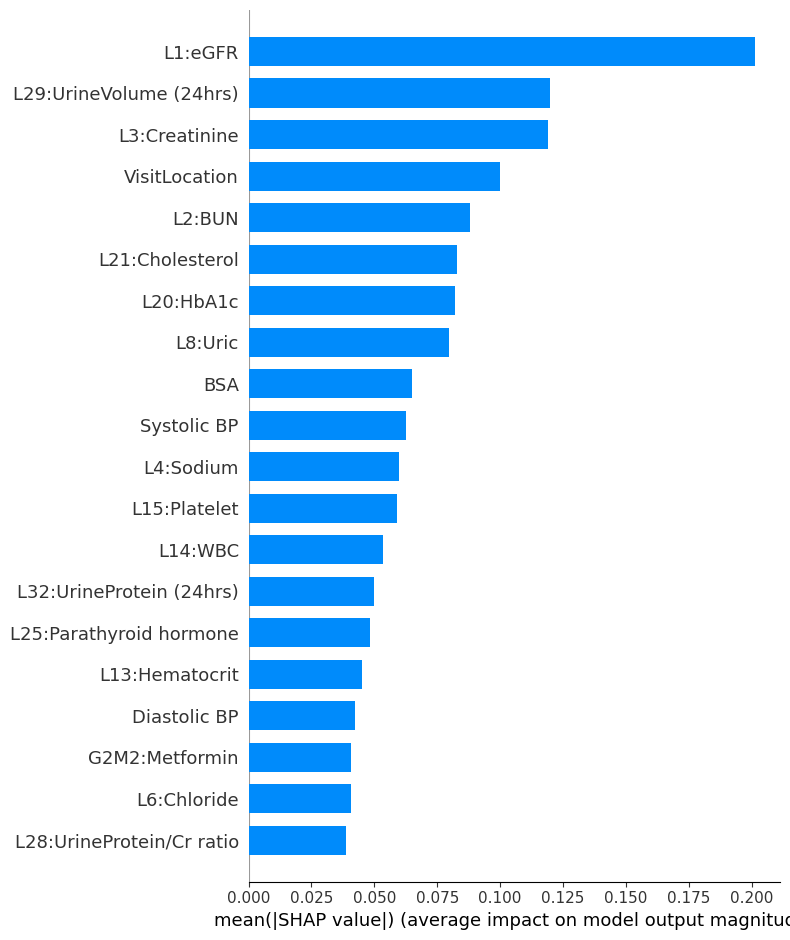

In [229]:
shap_values_aggregated = np.mean(shap_values, axis=2)

# Now reshape shap_values_aggregated to (52620, 120)
shap_values_reshaped = shap_values_aggregated.reshape(52620, 120)

# ใช้ shap.summary_plot โดยใส่ shap_values โดยตรง
shap.summary_plot(shap_values_reshaped, X, plot_type="bar")


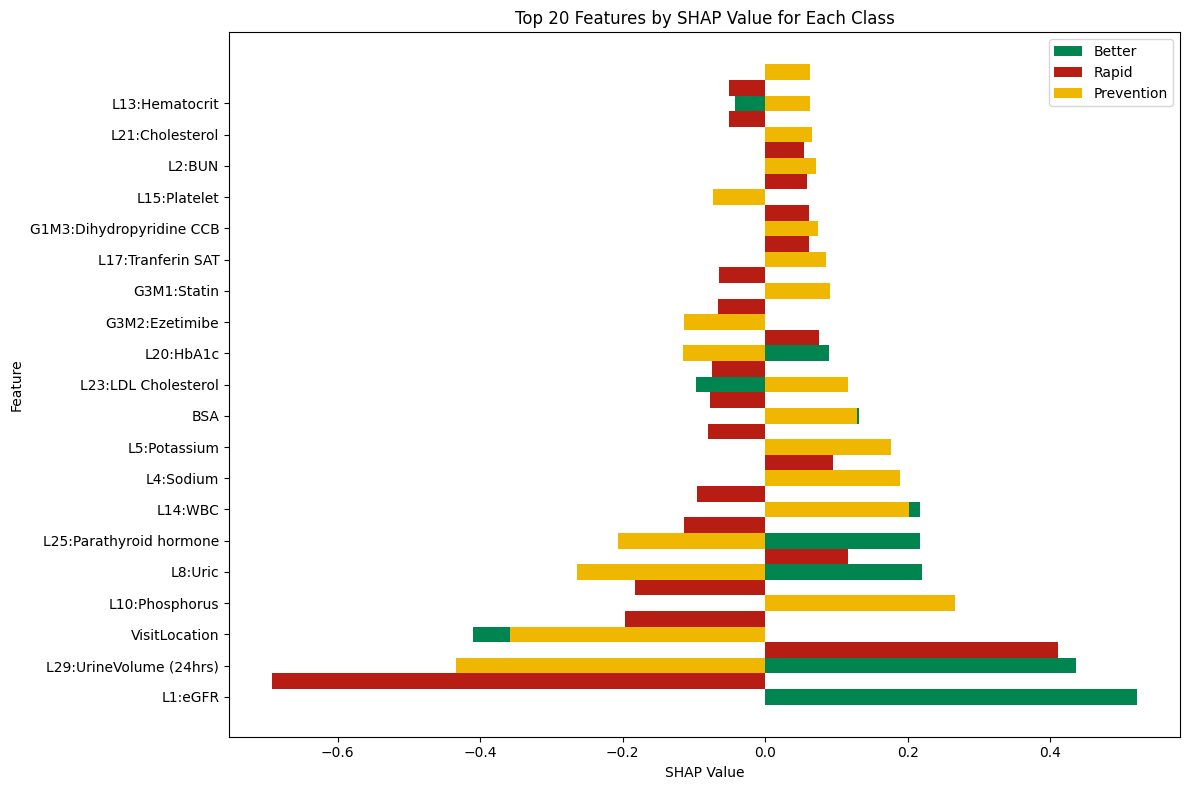

In [237]:
import numpy as np
import shap
import matplotlib.pyplot as plt

# Assuming shap_values is already defined

# Reshape shap_values if necessary
features_names = X.columns

# Define class labels
class_labels = ['Better', 'Rapid', 'Prevention']

# Plot SHAP summary plot as bar for every class
fig, ax = plt.subplots(figsize=(12, 8))

colors = ['#008450', '#B81D13', '#EFB700']
bar_width = 0.5

for class_index in range(shap_values.shape[2]):
    class_shap_values = shap_values[:, :, class_index]
    class_mean_shap_values = np.mean(class_shap_values, axis=0)
    sorted_indices = np.argsort(np.abs(class_mean_shap_values))[::-1]
    top_features_indices = sorted_indices[:20]
    top_feature_values = class_mean_shap_values[top_features_indices]
    ax.barh(np.arange(len(top_feature_values)) + class_index * bar_width, top_feature_values,
            height=bar_width, color=colors[class_index], label=class_labels[class_index])

ax.set_yticks(np.arange(len(top_features_indices)))
# Use feature names for y-axis labels
ax.set_yticklabels([f'{features_names[idx]}' for idx in top_features_indices], fontsize=10)
ax.set_xlabel('SHAP Value')
ax.set_ylabel('Feature')
ax.set_title('Top 20 Features by SHAP Value for Each Class')
ax.legend()

plt.tight_layout()
plt.show()


### Class 1: Rapid

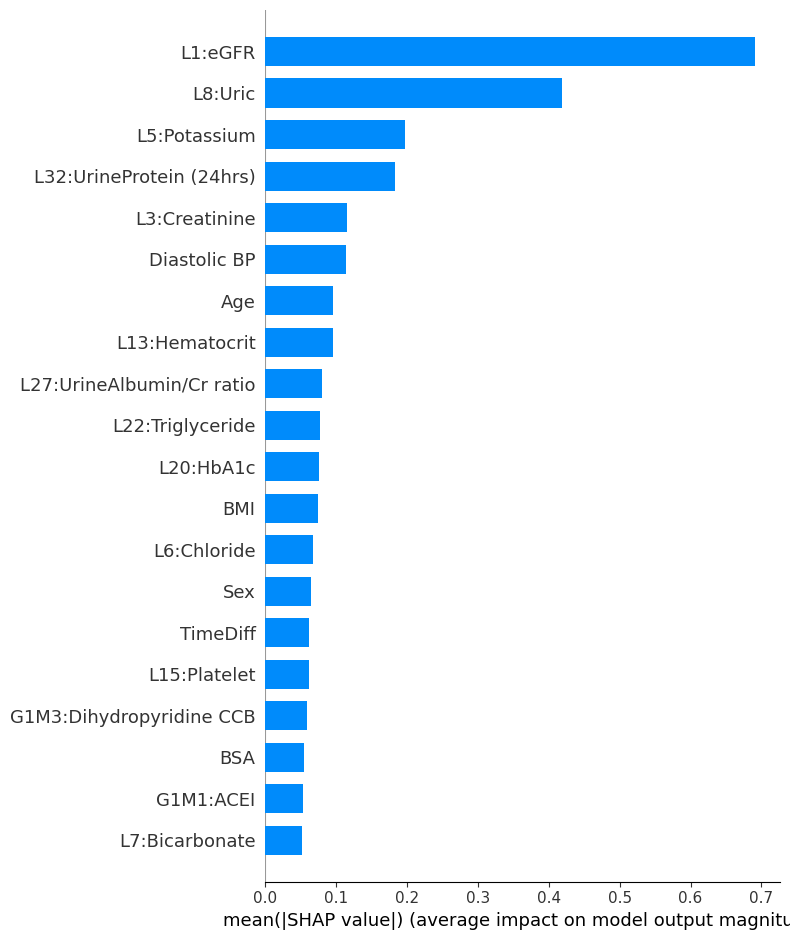

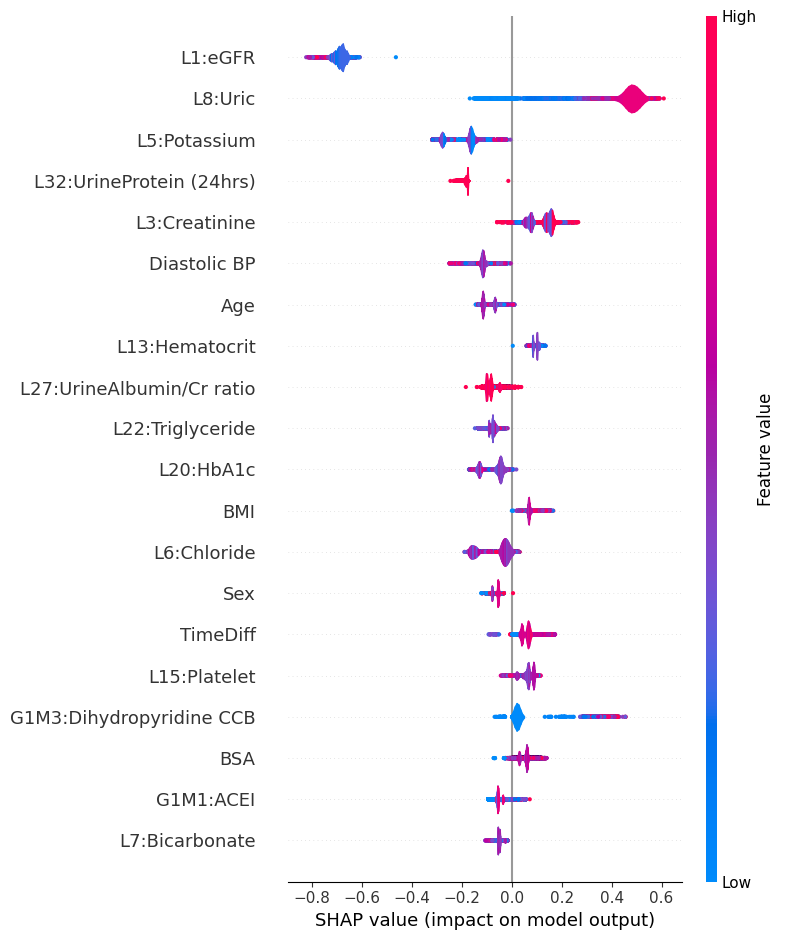

In [27]:
import shap
import matplotlib.pyplot as plt

# Assuming shap_values contains the SHAP values for each fold
fold_to_visualize = 0

# Assuming you want to visualize the first class ==> rapid
shap_values = shap_values_list[fold_to_visualize][:X.shape[0], :, 1]

# Summary Plot (Bar Plot)
shap.summary_plot(shap_values, X, feature_names=X.columns, plot_type="bar")

# Summary Plot (Violin Plot)
shap.summary_plot(shap_values, X, feature_names=X.columns, plot_type="violin")

plt.show()


### Class 2 : Prevention

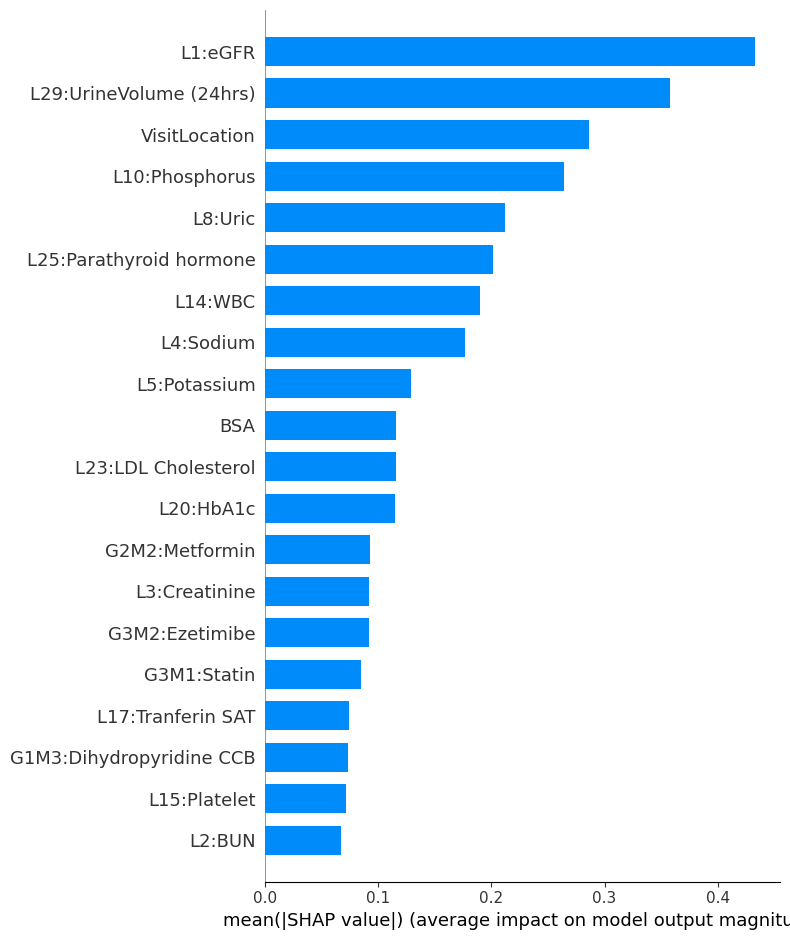

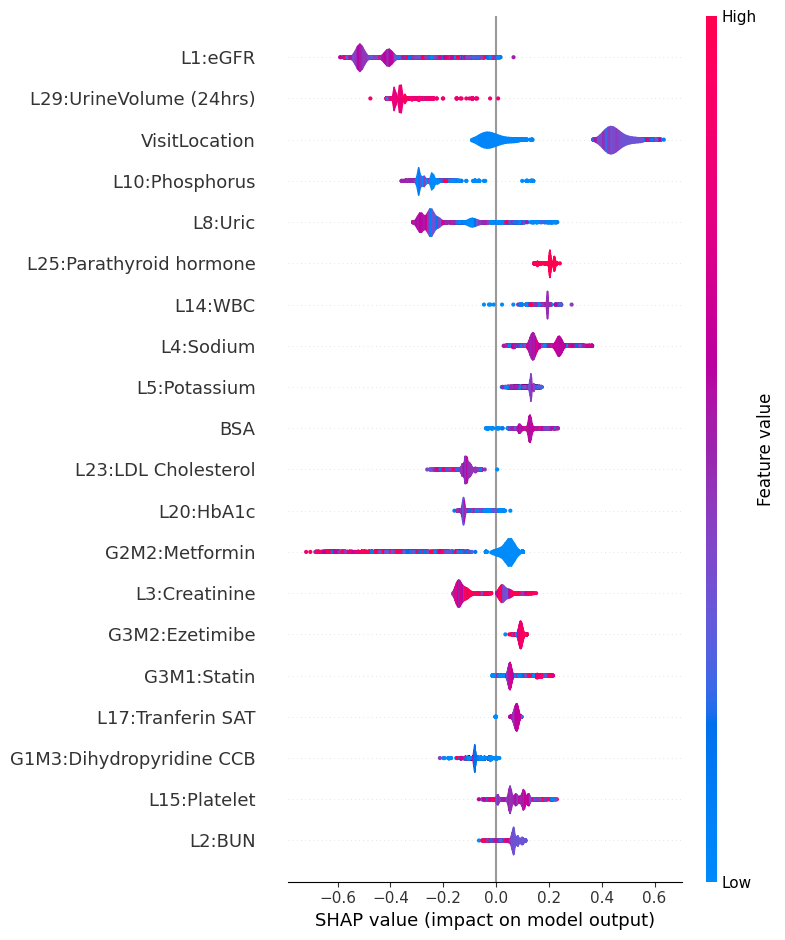

In [28]:
import shap
import matplotlib.pyplot as plt

# Assuming shap_values contains the SHAP values for each fold
fold_to_visualize = 0

# Assuming you want to visualize the first class ==> prevention
shap_values = shap_values_list[fold_to_visualize][:X.shape[0], :, 2]

# Summary Plot (Bar Plot)
shap.summary_plot(shap_values, X, feature_names=X.columns, plot_type="bar")

# Summary Plot (Violin Plot)
shap.summary_plot(shap_values, X, feature_names=X.columns, plot_type="violin")

plt.show()


# RF

In [30]:
from sklearn.ensemble import RandomForestClassifier
from joblib import Parallel, delayed
from sklearn.model_selection import GridSearchCV



```
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=None)
X = binary3.drop(['Group', 'PatientUID', 'PatientVisitUID', 'eGFR_t1', 'time_t1', 'StartDTTM', 'EndDttm',
                'LabCwhen', 'LabLocation', 'Fold','Slopes'], axis=1)
y = binary3['Group']
all_folds = binary3['Fold'].unique()
grid_search_results = []

binary3_y_pred_proba_rf = []
all_y_true_rf = []
all_y_pred_proba_rf = []

def train_and_evaluate(fold, train_indices, test_indices, X_train_scaled, X_test_scaled, y_train, y_test):
    rf_model = RandomForestClassifier()
    grid_search = GridSearchCV(rf_model, param_grid, scoring='accuracy', cv=num_folds, n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    best_params = grid_search.best_params_
    model_rf = RandomForestClassifier(**best_params, random_state=42)
    model_rf.fit(X_train_scaled, y_train)
    y_pred = model_rf.predict(X_test_scaled)
    y_pred_proba = model_rf.predict_proba(X_test_scaled)[:, 1]
    conf_mat = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    all_y_true_rf.extend(y_test)
    all_y_pred_proba_rf.extend(y_pred_proba)
    binary3_y_pred_proba_rf.append(y_pred_proba)
    return {
        'Fold': fold + 1,
        'Best Params': best_params,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': conf_mat,
        'Binary3 Y Pred Proba RF': binary3_y_pred_proba_rf,
        'All Y True RF': all_y_true_rf,
        'All Y Pred Proba RF': all_y_pred_proba_rf
    }

results = Parallel(n_jobs=-1)(
    delayed(train_and_evaluate)(
        fold,
        train_indices=binary3['Fold'].isin(train_folds),
        test_indices=(binary3['Fold'] == val_fold),
        X_train_scaled=scaler.fit_transform(X[train_indices]),
        X_test_scaled=scaler.transform(X[test_indices]),
        y_train=y[train_indices],
        y_test=y[test_indices]
    ) for fold, (train_folds, test_fold) in enumerate(kf.split(all_folds))
)
```



## RF Result from server

In [126]:
import pickle

file_path = '/content/drive/MyDrive/ckdresearch2023/Assign/GridSearch/binary3_y_pred_proba_rf.pkl'

with open(file_path, 'rb') as f:
    binary3_y_pred_proba_rf = pickle.load(f)

print(binary3_y_pred_proba_rf)

[array([0.51659366, 0.62150577, 0.32110666, ..., 0.31937761, 0.50891572,
       0.50452777]), array([0.54355079, 0.57556726, 0.34133415, ..., 0.32203777, 0.5502777 ,
       0.49087474]), array([0.53961517, 0.66590551, 0.33633699, ..., 0.30425621, 0.51097986,
       0.53923231]), array([0.55651143, 0.63337654, 0.34473059, ..., 0.33961426, 0.52312211,
       0.50178808]), array([0.50852646, 0.70183598, 0.36754762, ..., 0.26650794, 0.54972487,
       0.48976455])]


In [125]:
import json

json_file_path = '/content/drive/MyDrive/ckdresearch2023/Assign/GridSearch/all_y_true_rf.json'
with open(json_file_path, 'r') as f:
    all_y_true_rf = json.load(f)

print(all_y_true_rf)

[0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 0, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 0, 2, 1, 2, 1, 0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 0, 1, 0, 1, 0, 0, 2, 1, 0, 0, 1, 2, 1, 1, 1, 0, 2, 2, 1, 2, 1, 2, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 2, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 2, 1, 1, 2, 0, 2, 1, 0, 1, 0, 2, 0, 1, 0, 2, 1, 2, 2, 1, 0, 0, 2, 2, 1, 2, 1, 2, 2, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 2, 0, 0, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 1, 0, 1, 2, 1, 2, 1, 0, 1, 0, 1, 0, 2, 1, 0, 0, 2, 1, 2, 1, 2, 0, 1, 0, 2, 1, 0, 2, 2, 1, 2, 0, 2, 1, 2, 1, 0, 2, 1, 0, 1, 0, 1, 1, 1, 1, 2, 0, 1, 0, 2, 1, 0, 1, 1, 1, 2, 1, 2, 0, 2, 2, 1, 2, 2, 0, 2, 2, 1, 1, 1, 2, 1, 1, 2, 0, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 0, 0, 1, 2, 1, 1, 0, 1, 2, 1, 0, 1, 0, 0, 1, 1, 1, 2, 2, 1, 1, 2, 1, 0, 2, 1, 1, 0, 1, 1, 1, 2, 2, 2, 0, 2, 2, 1, 0, 1, 1, 0, 1, 2, 2, 1, 2, 0, 1, 2, 0, 1, 0, 1, 0, 2, 1, 0, 2, 1, 2, 0, 1, 0, 

In [131]:
import json

json_file_path = '/content/drive/MyDrive/ckdresearch2023/Assign/GridSearch/all_y_pred_proba_rf_list.json'
with open(json_file_path, 'r') as f:
    all_y_pred_proba_rf = json.load(f)

print(all_y_pred_proba_rf)

[0.5165936582272777, 0.6215057688835582, 0.3211066565711383, 0.3221613122046079, 0.3925292059553854, 0.26645834314837163, 0.42034046043431217, 0.320109727344167, 0.42466022167323936, 0.5362868821805361, 0.46367398914504804, 0.5196492829380337, 0.3913598362054831, 0.5168337280965257, 0.49420993307790356, 0.40475408855087075, 0.5521487001703348, 0.5938975128852978, 0.4810734972990511, 0.34978681264033973, 0.489929967288506, 0.4761259562223956, 0.4281467090396762, 0.3590389427834148, 0.5269131601917372, 0.5593793004208111, 0.648789560816042, 0.528083600917724, 0.5282576277600075, 0.5747560383236506, 0.5701344727460401, 0.45714453968173946, 0.3842445522551069, 0.2634831755552455, 0.43835767266993636, 0.5808948504506611, 0.3660870107339407, 0.5529733563314715, 0.5099906135890043, 0.2608943972714558, 0.20536567640191083, 0.1723377748965297, 0.21282003755744866, 0.416972703372125, 0.6381070553302652, 0.49565232276218846, 0.44649281794532214, 0.4947448350141206, 0.5403667243897496, 0.584843493

In [132]:
print(len(all_y_true_rf))
print(len(all_y_pred_proba_rf))

52965
52965


In [34]:
import pandas as pd
rf_metrics = pd.read_csv('/content/drive/MyDrive/ckdresearch2023/Assign/GridSearch/rf_metrics.csv')

In [35]:
rf_metrics = rf_metrics[['Fold','Accuracy', 'Precision', 'Recall', 'F1 Score']]
overall_metrics = rf_metrics.drop(columns='Fold').mean()
overall_metrics['Fold'] = 'Overall'

# Append the overall metrics without resetting the DataFrame
rf_metrics = rf_metrics.append(overall_metrics, ignore_index=True)

print("\nRandom Forest Performances:")
result_rf = rf_metrics.set_index('Fold')[['Accuracy', 'Precision', 'Recall', 'F1 Score']]
result_rf



Random Forest Performances:


<ipython-input-35-5a21130df126>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rf_metrics = rf_metrics.append(overall_metrics, ignore_index=True)


,Accuracy,Precision,Recall,F1 Score
Fold,,,,
1,0.526952,0.533324,0.526952,0.451785
2,0.527707,0.527797,0.527707,0.451790
3,0.526197,0.517444,0.526197,0.451279
4,0.526102,0.537625,0.526102,0.449731
5,0.526480,0.506827,0.526480,0.461012
Overall,0.526687,0.524603,0.526687,0.453119


In [36]:
print("\nRandom Forest Performances:")
print(result_rf)


Random Forest Performances:
         Accuracy  Precision    Recall  F1 Score
Fold                                            
1        0.526952   0.533324  0.526952  0.451785
2        0.527707   0.527797  0.527707  0.451790
3        0.526197   0.517444  0.526197  0.451279
4        0.526102   0.537625  0.526102  0.449731
5        0.526480   0.506827  0.526480  0.461012
Overall  0.526687   0.524603  0.526687  0.453119


## ROC

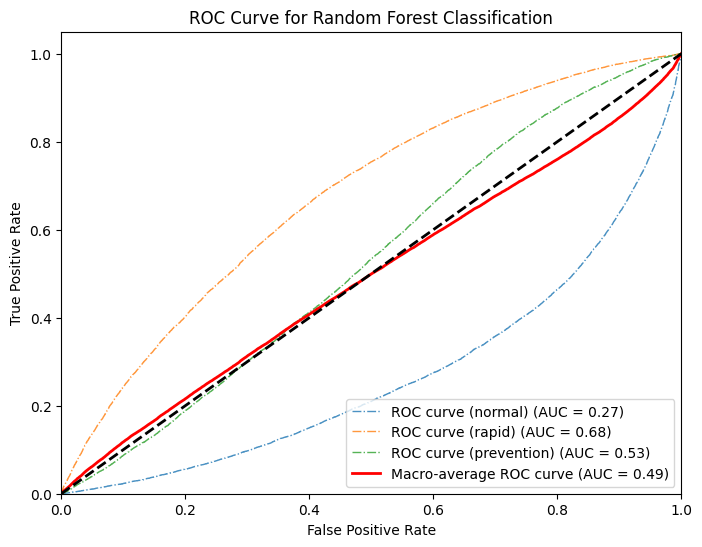

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming you have defined all_y_true_rf and all_y_pred_proba_rf somewhere

# Perform one-hot encoding on labels
all_y_true_rf_encoded = label_binarize(all_y_true_rf, classes=np.unique(all_y_true_rf))

# Define class labels
class_labels = {0: "normal", 1: "rapid", 2: "prevention"}

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, label in class_labels.items():
    fpr[i], tpr[i], _ = roc_curve(all_y_true_rf_encoded[:, i], all_y_pred_proba_rf)  # Modified this line
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_labels))]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(len(class_labels)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= len(class_labels)

# Calculate AUC for macro-average ROC
fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i, label in class_labels.items():
    plt.plot(fpr[i], tpr[i], lw=1, label=f'ROC curve ({label}) (AUC = {roc_auc[i]:.2f})', alpha = 0.8, linestyle='-.')

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, color='red', linestyle='solid', lw=2, label=f'Macro-average ROC curve (AUC = {roc_auc_macro:.2f})')

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classification')
plt.legend(loc="lower right")
plt.show()


# FNN

In [38]:
bi3_label_encoder = LabelEncoder()
bi3['Group'] = bi3_label_encoder.fit_transform(bi3['Group'])

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=None)
bi3_all_folds = bi3['Fold'].unique()

bi3_accuracy_per_fold = []
bi3_conf_mat_list = []

bi3_precision_per_fold = []
bi3_recall_per_fold = []
bi3_f1_per_fold = []

bi3_loss_per_fold = []
bi3_all_train_loss = []
bi3_all_val_loss = []

all_y_true_fnn = []
all_y_pred_proba_fnn = []


In [39]:
for fold, (train_folds, test_fold) in enumerate(kf.split(bi3_all_folds)):
    train_folds = bi3_all_folds[train_folds]
    test_fold = bi3_all_folds[test_fold][0]
    train_indices = bi3['Fold'].isin(train_folds)
    test_indices = bi3['Fold'] == test_fold

    bi3_X_train, bi3_X_test = bi3_X[train_indices], bi3_X[test_indices]
    bi3_y_train, bi3_y_test = bi3_y[train_indices], bi3_y[test_indices]

    # Scale
    bi3_scaler = StandardScaler()
    bi3_X_train_scaled = bi3_scaler.fit_transform(bi3_X_train)
    bi3_X_test_scaled = bi3_scaler.transform(bi3_X_test)

    # Encode y_train and y_test

    bi3_y_train_one_hot = tf.keras.utils.to_categorical(bi3_y_train, num_classes=3)
    bi3_y_test_one_hot = tf.keras.utils.to_categorical(bi3_y_test, num_classes=len(bi3_label_encoder.classes_))

    # Build and compile the model
    bi3_model = Sequential([
        Dense(256, input_dim=bi3_X_train_scaled.shape[1], activation='relu'),
        Dropout(0.6),
        Dense(128, activation='relu'),
        Dropout(0.6),
        Dense(64, activation='relu'),
        Dropout(0.6),
        Dense(3, activation='softmax')
    ])

    bi3_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    bi3_model.compile(optimizer=bi3_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    bi3_history = bi3_model.fit(bi3_X_train_scaled, bi3_y_train_one_hot,
                                batch_size=32,
                                epochs=80,
                                verbose=0,
                                validation_data=(bi3_X_test_scaled, bi3_y_test_one_hot))

    # Evaluate on the test set
    bi3_scores = bi3_model.evaluate(bi3_X_test_scaled, bi3_y_test_one_hot, verbose=0)
    bi3_loss_per_fold.append(bi3_scores[0])

    # Store metrics for analysis
    bi3_all_train_loss.append(bi3_history.history['loss'])
    bi3_all_val_loss.append(bi3_history.history['val_loss'])

    bi3_y_pred = bi3_model.predict(bi3_X_test_scaled)
    bi3_y_pred_classes = np.argmax(bi3_y_pred, axis=1)

    bi3_y_pred_proba_fnn = bi3_y_pred
    all_y_true_fnn.extend(binary3_y_test)
    all_y_pred_proba_fnn.extend(bi3_y_pred_proba_fnn[:, 1])

    bi3_conf_mat = confusion_matrix(bi3_y_test, bi3_y_pred_classes)
    bi3_conf_mat_list.append(bi3_conf_mat)

    bi3_accuracy = accuracy_score(bi3_y_test, bi3_y_pred_classes)
    bi3_precision = precision_score(bi3_y_test, bi3_y_pred_classes, average='weighted')
    bi3_recall = recall_score(bi3_y_test, bi3_y_pred_classes, average='weighted')
    bi3_f1 = f1_score(bi3_y_test, bi3_y_pred_classes, average='weighted')

    bi3_accuracy_per_fold.append(bi3_accuracy)
    bi3_precision_per_fold.append(bi3_precision)
    bi3_recall_per_fold.append(bi3_recall)
    bi3_f1_per_fold.append(bi3_f1)

332/332 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


324/324 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


327/327 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


333/333 [==============================] - 1s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


332/332 [==============================] - 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
import pandas as pd

# Create a DataFrame for performance metrics of each fold
fold_data = {
    "Fold": [f"Fold {fold+1}" for fold in range(len(bi3_accuracy_per_fold))],
    "Accuracy (%)": [accuracy * 100 for accuracy in bi3_accuracy_per_fold],
    "Precision": bi3_precision_per_fold,
    "Recall": bi3_recall_per_fold,
    "F1-Score": bi3_f1_per_fold
}

# Create DataFrame for fold performance
fold_performance_df = pd.DataFrame(fold_data).set_index("Fold")


# Calculate overall performance metrics
overall_metrics = {
    "Accuracy (%)": sum(bi3_accuracy_per_fold) / len(bi3_accuracy_per_fold) * 100,
    "Precision": sum(bi3_precision_per_fold) / len(bi3_precision_per_fold),
    "Recall": sum(bi3_recall_per_fold) / len(bi3_recall_per_fold),
    "F1-Score": sum(bi3_f1_per_fold) / len(bi3_f1_per_fold)
}

# Create DataFrame for overall performance
overall_performance_df = pd.DataFrame(overall_metrics, index=["Overall"])

# Concatenate fold performance DataFrame with overall performance DataFrame
result_fnn = pd.concat([fold_performance_df, overall_performance_df])

# Print the concatenated DataFrame
print("\nFNN Performance to classify Group:")
result_fnn


FNN Performance to classify Group:


,Accuracy (%),Precision,Recall,F1-Score
Fold 1,51.609553,0.383621,0.516096,0.438356
Fold 2,53.034989,0.397530,0.530350,0.451607
Fold 3,51.590648,0.394875,0.515906,0.428146
Fold 4,52.621688,0.394728,0.526217,0.448834
Fold 5,52.692634,0.395492,0.526926,0.449312
Overall,52.309902,0.393249,0.523099,0.443251


In [43]:
# Print the concatenated DataFrame
print("\nFNN Performance to classify Group:")
print(result_fnn)


FNN Performance to classify Group:
         Accuracy (%)  Precision    Recall  F1-Score
Fold 1      51.609553   0.383621  0.516096  0.438356
Fold 2      53.034989   0.397530  0.530350  0.451607
Fold 3      51.590648   0.394875  0.515906  0.428146
Fold 4      52.621688   0.394728  0.526217  0.448834
Fold 5      52.692634   0.395492  0.526926  0.449312
Overall     52.309902   0.393249  0.523099  0.443251


## ROC

In [61]:
print(bi3_y_pred_proba_fnn.shape)
print(bi3_y_test.shape)

(10603, 3)
(10603,)


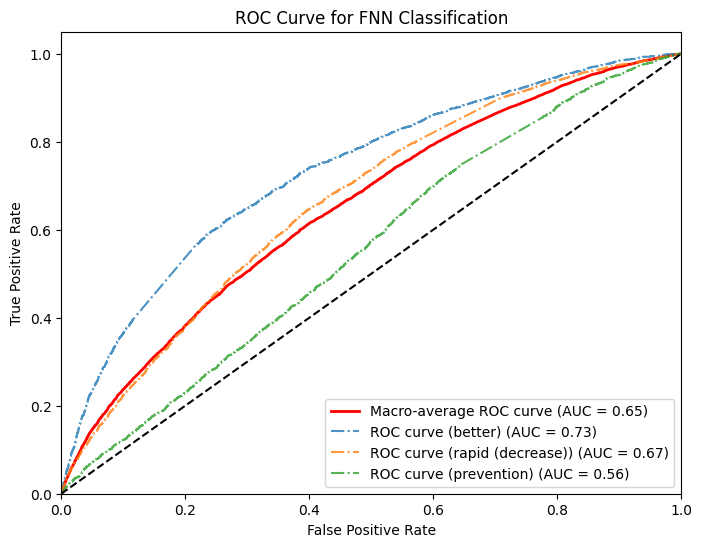

In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Convert true labels to one-hot encoded format
bi3_y_test_bin = label_binarize(bi3_y_test, classes=np.unique(bi3_y_test))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = bi3_y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(bi3_y_test_bin[:, i], bi3_y_pred_proba_fnn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and AUC
# First, aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally, average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

class_labels = {0: "better", 1: "rapid (decrease)", 2: "prevention"}

# Plot ROC curve
plt.figure(figsize=(8, 6))

plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:0.2f})', color='red', linestyle='solid', linewidth=2)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve ({class_labels[i]}) (AUC = {roc_auc[i]:0.2f})', alpha = 0.8, linestyle = '-.')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for FNN Classification')
plt.legend(loc="lower right")
plt.show()


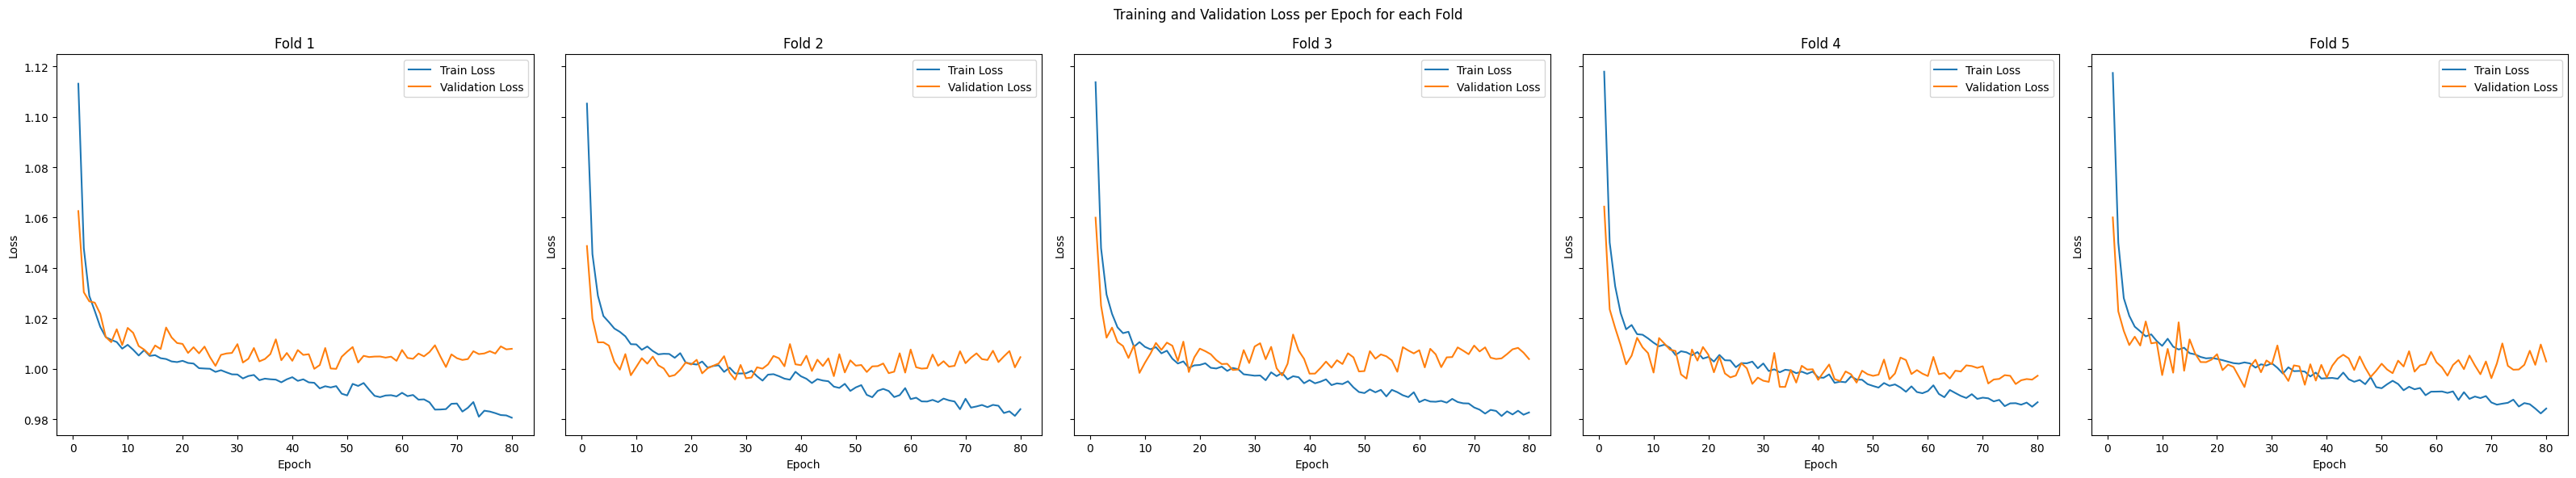

In [49]:
import matplotlib.pyplot as plt

num_epochs = len(bi3_all_train_loss[0])  # Assuming all folds have the same number of epochs

fig, axs = plt.subplots(1, num_folds, figsize=(32, 6), sharex=True, sharey=True)

for fold in range(num_folds):
    axs[fold].plot(range(1, num_epochs + 1), bi3_all_train_loss[fold], label=f'Train Loss')
    axs[fold].plot(range(1, num_epochs + 1), bi3_all_val_loss[fold], label=f'Validation Loss')
    axs[fold].set_title(f'Fold {fold + 1}')
    axs[fold].set_xlabel('Epoch')
    axs[fold].set_ylabel('Loss')
    axs[fold].legend()

plt.suptitle('Training and Validation Loss per Epoch for each Fold')
plt.tight_layout()
plt.show()


## shap

In [46]:
explainer = shap.Explainer(bi3_model, bi3_X_train_scaled)
shap_values = explainer.shap_values(bi3_X_train_scaled[:100])

PermutationExplainer explainer: 101it [00:34,  2.43it/s]


In [47]:
print(shap_values.shape)
print(bi3_X_train_scaled[:100].shape)

(100, 120, 3)
(100, 120)


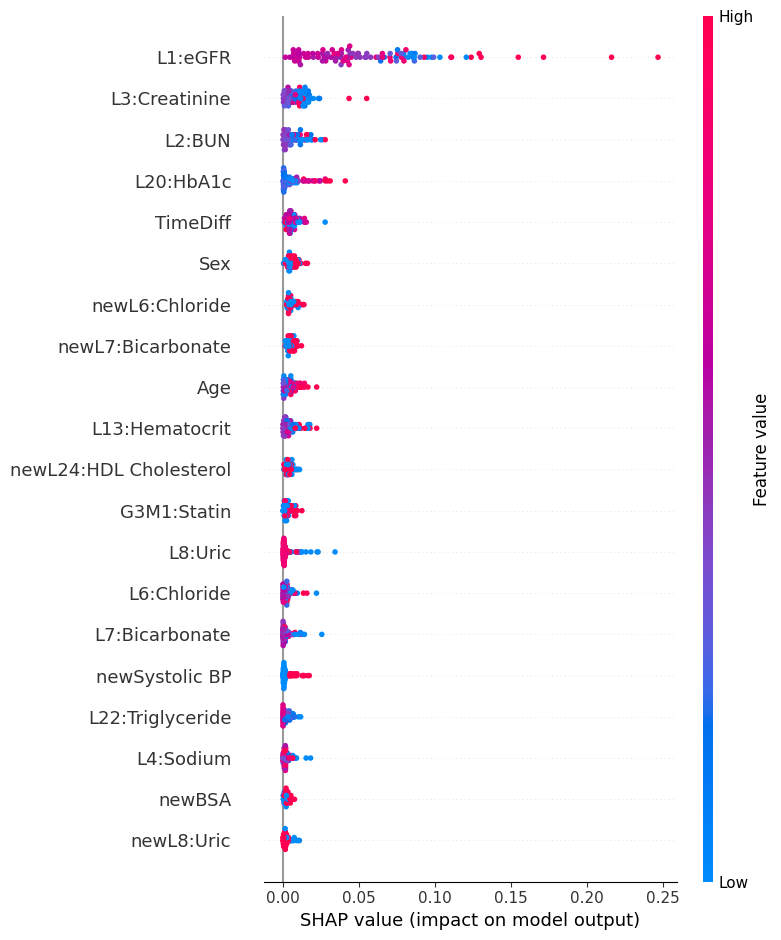

In [48]:
# Reshape shap_values array
shap_values_reshaped = np.mean(np.abs(shap_values), axis=2)

# Call summary_plot
shap.summary_plot(shap_values_reshaped, bi3_X_train_scaled[:100], feature_names=bi3_X.columns)

# SVC

In [64]:
from sklearn.svm import SVC
from sklearn import svm

In [66]:
binary3_X = bi3.drop(['Group', 'PatientUID', 'PatientVisitUID', 'eGFR_t1', 'time_t1', 'StartDTTM', 'EndDttm',
               'LabCwhen', 'LabLocation','Fold','Slopes','Stage'], axis=1)
binary3_y = bi3['Group']

In [67]:
binary3_label_encoder = LabelEncoder()
bi3['Group'] = binary3_label_encoder.fit_transform(bi3['Group'])

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=None)
binary3_all_folds = bi3['Fold'].unique()

svc_metrics_list = []
binary3_accuracy_per_fold = []
binary3_conf_mat_list = []
binary3_precision_per_fold = []
binary3_recall_per_fold = []
binary3_f1_per_fold = []
binary3_loss_per_fold = []

all_y_true_svc = []
all_y_pred_proba_svc = []



```
for fold, (train_folds, test_fold) in enumerate(kf.split(binary3_all_folds)):
    train_folds = binary3_all_folds[train_folds]
    test_fold = binary3_all_folds[test_fold][0]
    train_indices = bi3['Fold'].isin(train_folds)
    test_indices = bi3['Fold'] == test_fold

    binary3_X_train, binary3_X_test = binary3_X[train_indices], binary3_X[test_indices]
    binary3_y_train, binary3_y_test = binary3_y[train_indices], binary3_y[test_indices]

    # Scale
    binary3_scaler = StandardScaler()
    binary3_X_train_scaled = binary3_scaler.fit_transform(binary3_X_train)
    binary3_X_test_scaled = binary3_scaler.transform(binary3_X_test)

    # Create and train SVC model using best parameters
    model_svc = svm.SVC(decision_function_shape='ovo', probability=True)
    model_svc.fit(binary3_X_train_scaled, binary3_y_train)

    # Make predictions on the test set
    binary3_y_pred = model_svc.predict(binary3_X_test_scaled)

    binary3_y_pred_proba_svc = model_svc.decision_function(binary3_X_test_scaled)
    all_y_true_svc.extend(binary3_y_test)
    all_y_pred_proba_svc.extend(binary3_y_pred_proba_svc[:, 1])

    # Evaluate performance
    binary3_conf_mat = confusion_matrix(binary3_y_test, binary3_y_pred)
    binary3_conf_mat_list.append(binary3_conf_mat)
    binary3_accuracy = accuracy_score(binary3_y_test, binary3_y_pred)
    binary3_precision = precision_score(binary3_y_test, binary3_y_pred, average='weighted')
    binary3_recall = recall_score(binary3_y_test, binary3_y_pred, average='weighted')
    binary3_f1 = f1_score(binary3_y_test, binary3_y_pred, average='weighted')
    
    binary3_accuracy_per_fold.append(binary3_accuracy)
    binary3_precision_per_fold.append(binary3_precision)
    binary3_recall_per_fold.append(binary3_recall)
    binary3_f1_per_fold.append(binary3_f1)

    svc_metrics_list.append({
        'Fold': fold + 1,
        'Accuracy': binary3_accuracy_per_fold,
        'Precision': binary3_precision_per_fold,
        'Recall': binary3_recall_per_fold,
        'F1 Score': binary3_f1_per_fold,
    })
```



## Result from server

In [68]:
result_svc = pd.read_csv('/content/drive/MyDrive/ckdresearch2023/Assign/GridSearch/result_svc.csv')

In [69]:
print("\n Support Vector Classification Performances:")
print(result_svc)


 Support Vector Classification Performances:
  Unnamed: 0  Accuracy (%)  Precision    Recall  F1-Score
0     Fold 1     51.411309   0.483219  0.514113  0.438821
1     Fold 2     52.745022   0.492369  0.527450  0.450426
2     Fold 3     51.982710   0.475439  0.519827  0.442754
3     Fold 4     51.945190   0.481012  0.519452  0.442359
4     Fold 5     52.485146   0.504197  0.524851  0.448523
5    Overall     52.113875   0.487247  0.521139  0.444577


## ROC

In [70]:
# Load the array
import numpy as np
binary3_y_pred_proba_svc = np.load('/content/drive/MyDrive/ckdresearch2023/Assign/GridSearch/binary3_y_pred_proba_svc.npy')

# Now you can use binary3_y_pred_proba_svc in your Colab notebook
print(binary3_y_pred_proba_svc)

[[-0.02650403  0.52128657  0.76594442]
 [-0.28683925 -0.09056781  0.81931317]
 [ 0.10690912  0.22974389  0.85456098]
 ...
 [-0.10817442  1.20458718  1.04993297]
 [ 0.31241888  1.06616499  0.93443532]
 [-0.85368739 -0.78824982  0.69518793]]


In [74]:
print(binary3_y_pred_proba_svc.shape)

(10603, 3)


In [75]:
print(bi3_y_test_bin.shape)

(10603, 3)


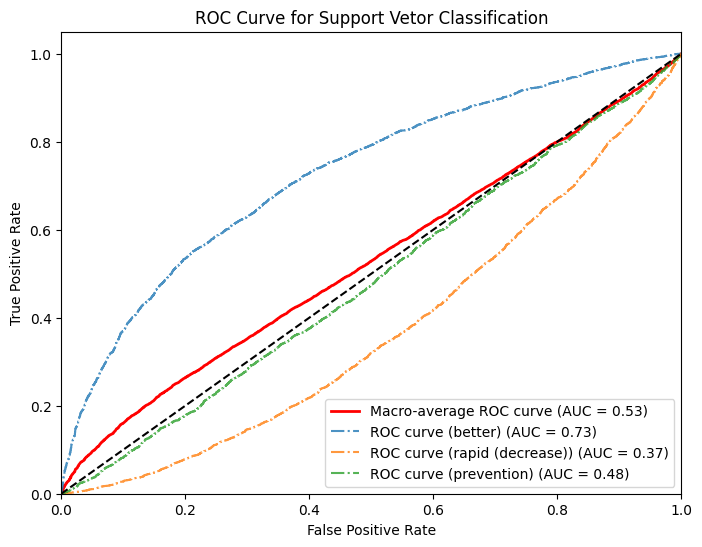

In [77]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Convert true labels to one-hot encoded format
binary3_y_test_bin = label_binarize(bi3_y_test, classes=np.unique(bi3_y_test))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = binary3_y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(bi3_y_test_bin[:, i], binary3_y_pred_proba_svc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and AUC
# First, aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally, average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

class_labels = {0: "better", 1: "rapid (decrease)", 2: "prevention"}

# Plot ROC curve
plt.figure(figsize=(8, 6))

plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:0.2f})', color='red', linestyle='solid', linewidth=2)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve ({class_labels[i]}) (AUC = {roc_auc[i]:0.2f})', alpha = 0.8, linestyle = '-.')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Support Vetor Classification')
plt.legend(loc="lower right")
plt.show()


#Summary

In [78]:
result_rf['Accuracy'] *= 100

In [83]:
test = pd.concat([result_xgb[-1:], result_rf[-1:], result_fnn[-1:], result_svc[-1:]], keys=['XGBoost', 'RandomForest', 'Feedforward Neural Network', 'Support Vector Machine'])
import pandas as pd

# Concatenating the DataFrames
test = pd.concat([result_xgb.iloc[-1:], result_rf.iloc[-1:], result_fnn.iloc[-1:], result_svc[-1:]], keys=['XGBoost', 'RandomForest', 'Feedforward Neural Network', 'Support Vector Machine'])

# Remove the index named 'Overall'
test.reset_index(level=1, drop=True, inplace=True)

# Renaming the 'F1 Score' column in the RandomForest section
test.loc['RandomForest', 'F1-Score'] = test.loc['RandomForest', 'F1 Score']
test.drop(columns='F1 Score', inplace=True)
# Renaming the 'F1 Score' column in the RandomForest section
test.loc['RandomForest', 'Accuracy (%)'] = test.loc['RandomForest', 'Accuracy']
test.drop(columns='Accuracy', inplace=True)
test.drop(columns='Unnamed: 0', inplace =True)

In [84]:
print(test)

                            Accuracy (%)  Precision    Recall  F1-Score
XGBoost                        53.534079   0.510090  0.535341  0.473611
RandomForest                   52.668744   0.524603  0.526687  0.453119
Feedforward Neural Network     52.309902   0.393249  0.523099  0.443251
Support Vector Machine         52.113875   0.487247  0.521139  0.444577


## avg ROC

In [103]:
all_y_true_rf_encoded = np.array(all_y_true_rf_encoded)
all_y_pred_proba_rf = np.array(all_y_pred_proba_rf)

In [105]:
all_y_pred_proba_rf = np.array(all_y_pred_proba_rf)  # Convert to numpy array if it's not already
all_y_pred_proba_rf = all_y_pred_proba_rf.reshape(-1, 3)  # Reshape to match the shape of all_y_true_rf_encoded

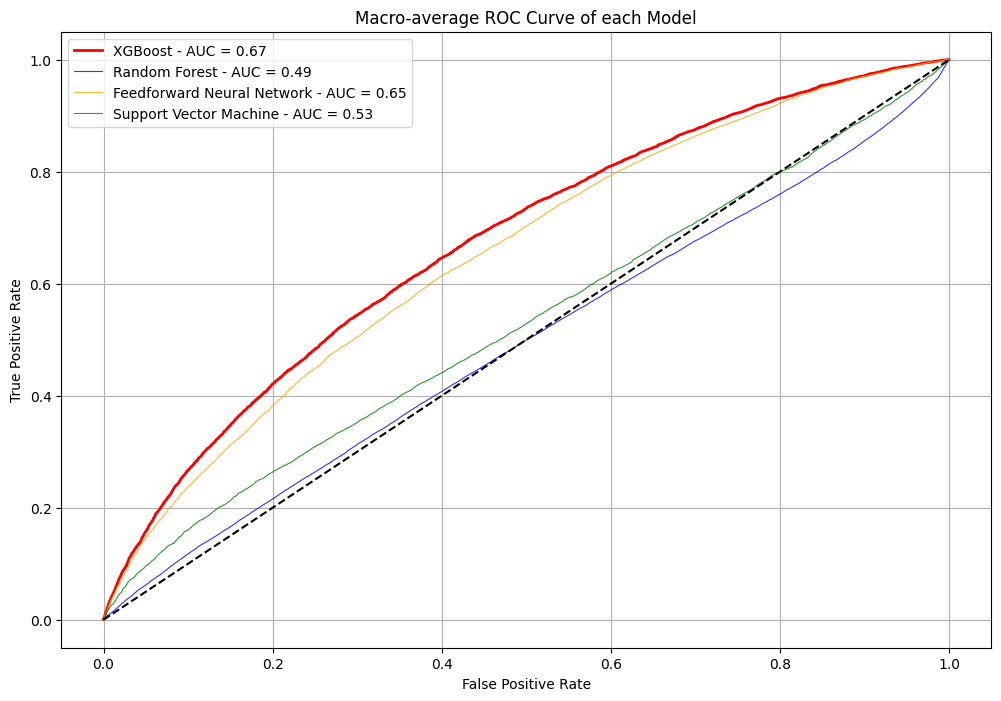

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# Assuming you have defined all_y_true_rf, all_y_pred_proba_rf, all_y_pred_proba_xgb, bi3_y_test,
# bi3_y_pred_proba_fnn, binary3_y_pred_proba_svc, binary3_y_test, binary3_y_pred_proba_xgb, binary3_y_pred_proba_svc somewhere

# Convert true labels to one-hot encoded format
all_y_true_rf_encoded = label_binarize(all_y_true_rf, classes=np.unique(all_y_true_rf))
binary3_y_test_bin = label_binarize(binary3_y_test, classes=np.unique(binary3_y_test))
bi3_y_test_bin = label_binarize(bi3_y_test, classes=np.unique(bi3_y_test))

# Define class labels
class_labels = {0: "better", 1: "rapid (decrease)", 2: "prevention"}

# Compute ROC curve and AUC for XGBoost for each class separately
fpr_xgb = dict()
tpr_xgb = dict()
roc_auc_xgb = dict()

n_classes_xgb = binary3_y_test_bin.shape[1]
for i in range(n_classes_xgb):
    fpr_xgb[i], tpr_xgb[i], _ = roc_curve(binary3_y_test_bin[:, i], binary3_y_pred_proba_xgb[:, i])
    roc_auc_xgb[i] = auc(fpr_xgb[i], tpr_xgb[i])

# Compute ROC curve and AUC for Random Forest (rf) for each class separately
fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()

# Define class labels
for i, label in class_labels.items():
    fpr_rf[i], tpr_rf[i], _ = roc_curve(all_y_true_rf_encoded[:, i], all_y_pred_proba_rf)
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])


# Calculate AUC for macro-average ROC
fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Compute ROC curve and AUC for FNN for each class separately
fpr_fnn = dict()
tpr_fnn = dict()
roc_auc_fnn = dict()

n_classes_fnn = bi3_y_test_bin.shape[1]
for i in range(n_classes_fnn):
    fpr_fnn[i], tpr_fnn[i], _ = roc_curve(bi3_y_test_bin[:, i], bi3_y_pred_proba_fnn[:, i])
    roc_auc_fnn[i] = auc(fpr_fnn[i], tpr_fnn[i])

# Compute ROC curve and AUC for SVC for each class separately
fpr_svc = dict()
tpr_svc = dict()
roc_auc_svc = dict()

n_classes_svc = binary3_y_test_bin.shape[1]
for i in range(n_classes_svc):
    fpr_svc[i], tpr_svc[i], _ = roc_curve(bi3_y_test_bin[:, i], binary3_y_pred_proba_svc[:, i])
    roc_auc_svc[i] = auc(fpr_svc[i], tpr_svc[i])

# Compute macro-average ROC curve and AUC for XGBoost
all_fpr_xgb = np.unique(np.concatenate([fpr_xgb[i] for i in range(n_classes_xgb)]))
mean_tpr_xgb = np.zeros_like(all_fpr_xgb)
for i in range(n_classes_xgb):
    mean_tpr_xgb += np.interp(all_fpr_xgb, fpr_xgb[i], tpr_xgb[i])
mean_tpr_xgb /= n_classes_xgb
fpr_macro_xgb = all_fpr_xgb
tpr_macro_xgb = mean_tpr_xgb
roc_auc_macro_xgb = auc(fpr_macro_xgb, tpr_macro_xgb)

# Compute macro-average ROC curve and AUC for Random Forest (rf)
all_fpr_rf = np.unique(np.concatenate([fpr_rf[i] for i in range(n_classes_rf)]))
mean_tpr_rf = np.zeros_like(all_fpr_rf)
for i in range(len(class_labels)):
    mean_tpr_rf += np.interp(all_fpr_rf, fpr_rf[i], tpr_rf[i])
mean_tpr_rf /= len(class_labels)
fpr_macro_rf = all_fpr_rf
tpr_macro_rf = mean_tpr_rf
roc_auc_macro_rf = auc(fpr_macro_rf, tpr_macro_rf)

# Compute macro-average ROC curve and AUC for FNN
all_fpr_fnn = np.unique(np.concatenate([fpr_fnn[i] for i in range(n_classes_fnn)]))
mean_tpr_fnn = np.zeros_like(all_fpr_fnn)
for i in range(n_classes_fnn):
    mean_tpr_fnn += np.interp(all_fpr_fnn, fpr_fnn[i], tpr_fnn[i])
mean_tpr_fnn /= n_classes_fnn
fpr_macro_fnn = all_fpr_fnn
tpr_macro_fnn = mean_tpr_fnn
roc_auc_macro_fnn = auc(fpr_macro_fnn, tpr_macro_fnn)

# Compute macro-average ROC curve and AUC for SVC
all_fpr_svc = np.unique(np.concatenate([fpr_svc[i] for i in range(n_classes_svc)]))
mean_tpr_svc = np.zeros_like(all_fpr_svc)
for i in range(n_classes_svc):
    mean_tpr_svc += np.interp(all_fpr_svc, fpr_svc[i], tpr_svc[i])
mean_tpr_svc /= n_classes_svc
fpr_macro_svc = all_fpr_svc
tpr_macro_svc = mean_tpr_svc
roc_auc_macro_svc = auc(fpr_macro_svc, tpr_macro_svc)

plt.figure(figsize=(12, 8))
# Plot macro-average ROC curve
plt.plot(fpr_macro_xgb, tpr_macro_xgb, label=f'XGBoost - AUC = {roc_auc_macro_xgb:.2f}', color='red', linestyle='solid', lw=2)
plt.plot(fpr_macro_rf, tpr_macro_rf, label=f'Random Forest - AUC = {roc_auc_macro_rf:.2f}', color='blue', linestyle='solid', alpha=0.8, lw=0.8)
plt.plot(fpr_macro_fnn, tpr_macro_fnn, label=f'Feedforward Neural Network - AUC = {roc_auc_macro_fnn:.2f}', color='orange', linestyle='solid', alpha=0.8, lw=0.8)
plt.plot(fpr_macro_svc, tpr_macro_svc, label=f'Support Vector Machine - AUC = {roc_auc_macro_svc:.2f}', color='green', linestyle='solid', alpha=0.8, lw=0.8)

# Plot the center diagonal line
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

plt.title('Macro-average ROC Curve of each Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()
